In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from src.data.some_dataloader import *
import matplotlib.pyplot as plt
from article_to_country import *

### This notebooks shows how the countries are extracted from the wikipedia plaintext articles

First a naive approach is used by doing a text search and finding all the country string names inside the plaintext.

In [3]:
country_data = country_occurences_in_files()
counts = filter_top_k(country_data, k=2, N=1)

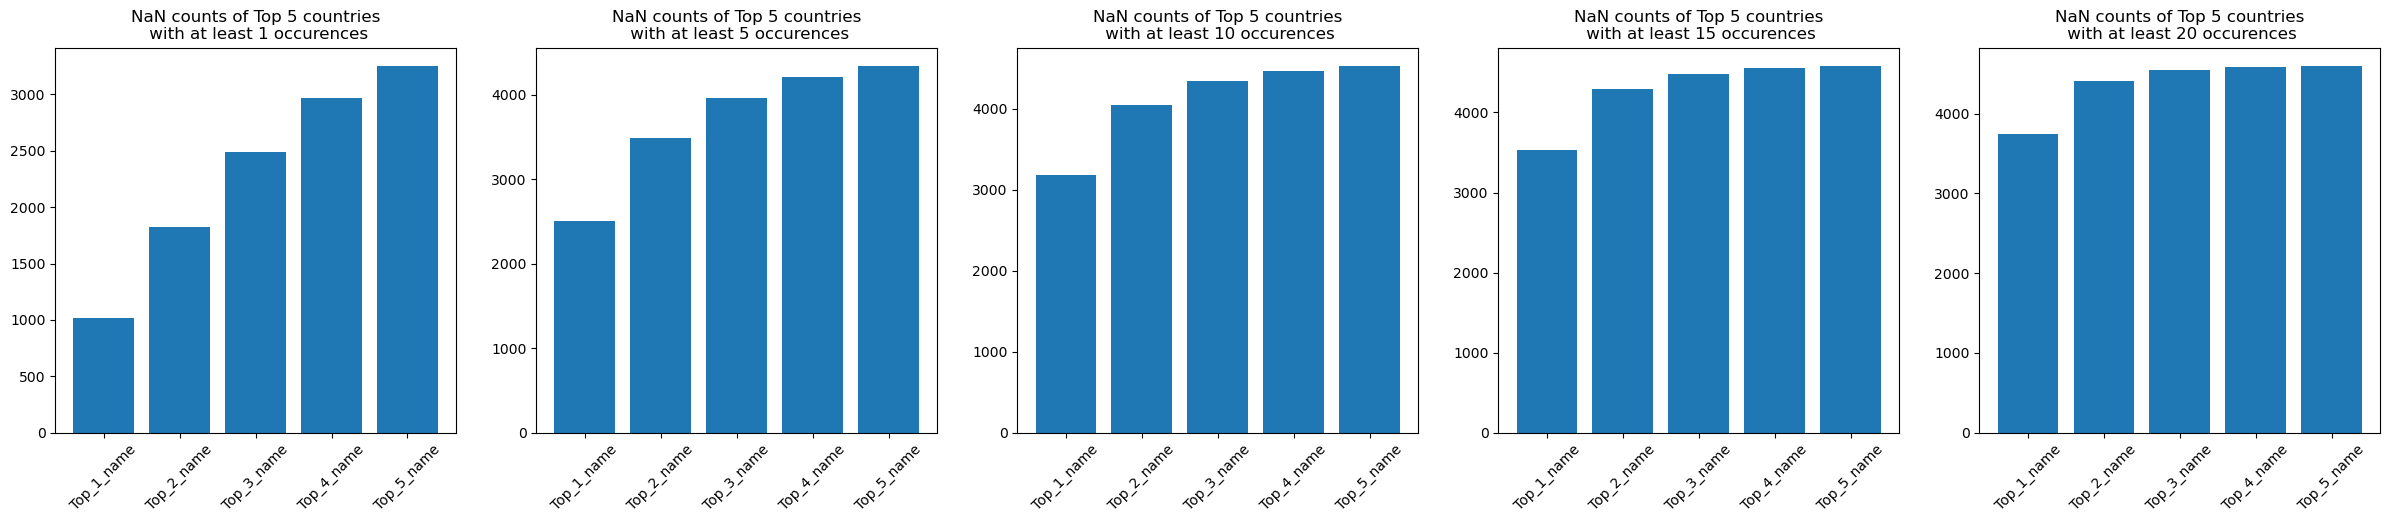

In [4]:
N_samples = [1, 5, 10, 15, 20]
K = 5

fig, axs = plt.subplots(1, len(N_samples), figsize=(30, 5))

i = 0
for j, N in enumerate(N_samples):
    counts = filter_top_k(country_data, k=K, N=N)
    df_cleaned = counts.iloc[:, :K]
    df_stat = df_cleaned.isna().sum()
    axs[j].bar(df_stat.index, df_stat)
    axs[j].set_title(f"NaN counts of Top {K} countries\n with at least {N} occurences")
    
    axs[j].xaxis.set_tick_params(rotation=45)

From the previous cell it was clear that in order to classify the articles we needed to pick a small number of occurences (N = 1) in order to avoid discarding more than half of the articles. 

In [5]:
nan_df = counts[counts.isna().all(axis=1)]
print(f"Number of articles with no countries before completion with llama: {len(nan_df)}")


Number of articles with no countries before completion with llama: 3740


This approach resulted in 1015 articles having no country assigned to them. By going manually through them it can be seen that as a human some articles can be further classified to countries even if not explicitely mentionned in the text. 

### Further classifying articles to countires with the help of small llm's

Two LLM's were tested and only Llama (a Meta LLM) was retained in order to assign the missing articles to countries. Fot this to be done the LLM was downloaded locally and used for inference on the plaintext articles. 

The format of the prompt used to let the model classify articles to countries was : 
```
<system_prompt_begin>
You will be given textual articles. For each article provide single and unique country to which the article is related and should be classified to. Provide the answer in the form : <country>. If there is no country related to the article, please write 'None'. If the location is not on earth, please write 'None'. You must be 100\% sure this is a question of life or death.
<system_prompt_end>

<user_prompt_begin>
plaintext article
<user_prompt_end>
```

In order to run this execute the following cell : 
Note : It was already preprocessed so this can also be skipped and the  ```data/country_occurences_inferrence.csv``` can be loaded

In [6]:
# !python article_to_country.py

In [8]:
refined_data = pd.read_csv("data/country_occurences.csv", index_col=0)
nan_df = refined_data[refined_data.isna().all(axis=1)]
print(f"Number of articles with no countries after completion with llama: {len(nan_df)}")

Number of articles with no countries after completion with llama: 644


This approach allowed to classify 1015 - 508 = 507 new articles having no country assigned to them. In the cell below it can be seen which articles were classified with help of the LLM (the ones having a "Top_1_count" of 0 meaning 0 occurences of this exact substring in the text but still classified as this country by the llm)

In [9]:
refined_data[refined_data["Top_1_count"] == 0].head(10)

,Top_1_name,Top_2_name,Top_1_count,Top_2_count
1980_eruption_of_Mount_St._Helens,united states,NaN,0.0,NaN
4-2-0,united states,NaN,0.0,NaN
4-6-0,united states,NaN,0.0,NaN
6-2-0,united states,NaN,0.0,NaN
8th_century,united kingdom,NaN,0.0,NaN
Abbadid,spain,NaN,0.0,NaN
Abstract_art,russia,NaN,0.0,NaN
Achilles_tendon,greece,NaN,0.0,NaN
African_Black_Oystercatcher,south africa,NaN,0.0,NaN
African_clawed_frog,south africa,NaN,0.0,NaN


Text(0.5, 1.0, 'Top 40 countries occurences in the articles')

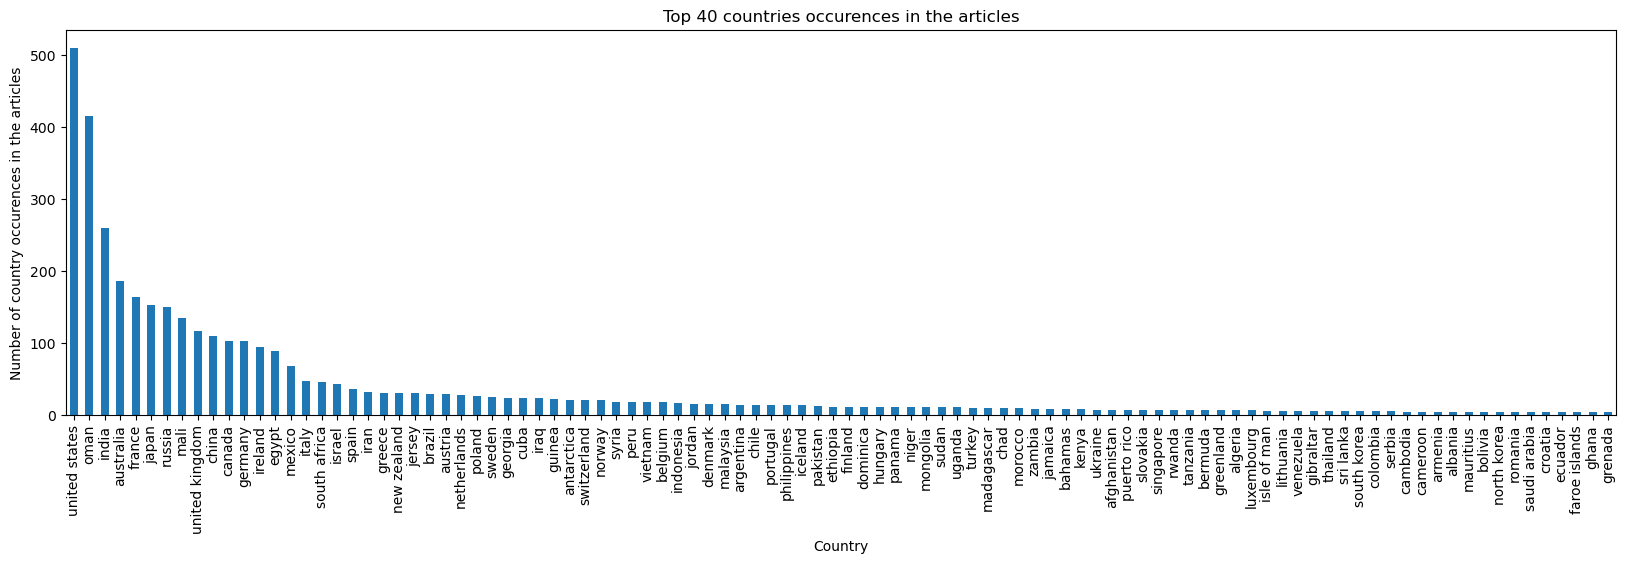

In [10]:
refined_data.groupby("Top_1_name").size().sort_values(ascending=False).head(100).plot(kind="bar", figsize=(20, 5))

plt.ylabel("Number of country occurences in the articles")
plt.xlabel("Country")

plt.title("Top 40 countries occurences in the articles")

Text(0.5, 1.0, 'Top 40 countries occurences in the articles')

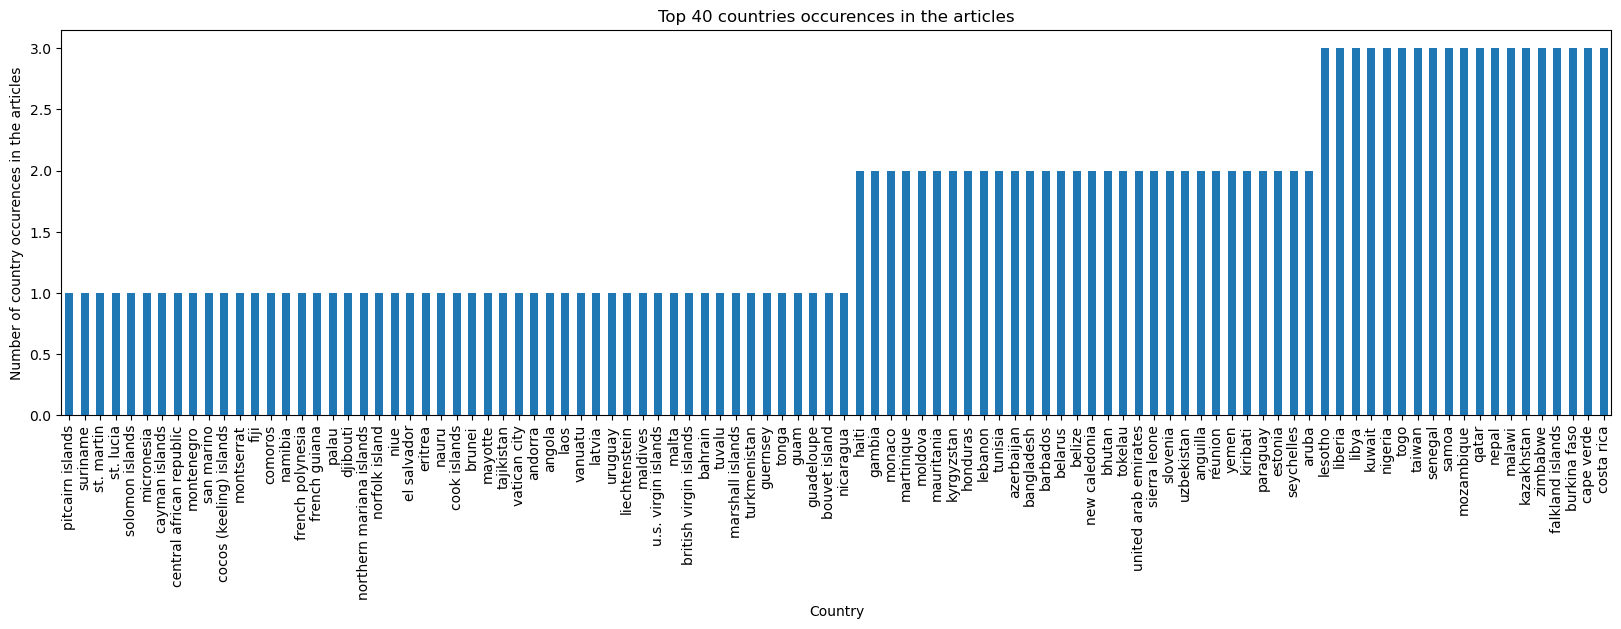

In [11]:
refined_data.groupby("Top_1_name").size().sort_values(ascending=True).head(100).plot(kind="bar", figsize=(20, 5))

plt.ylabel("Number of country occurences in the articles")
plt.xlabel("Country")

plt.title("Top 40 countries occurences in the articles")

In [48]:
from ast import literal_eval
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].fillna("[]")
country_clicks["num_links_in"] = country_clicks["num_links_in"].fillna(0)
country_clicks["num_links_out"] = country_clicks["num_links_out"].fillna(0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].apply(literal_eval)

In [ ]:
l = []

for idx, row in country_clicks.iterrows():
    links_out_list = list(row["name_links_out"])
    for out_link in links_out_list:
        l.append(f"{row['Top_1_name']} -> {country_clicks.loc[out_link]['Top_1_name']}")

Text(0.5, 1.0, 'Top 100 country links by occurences')

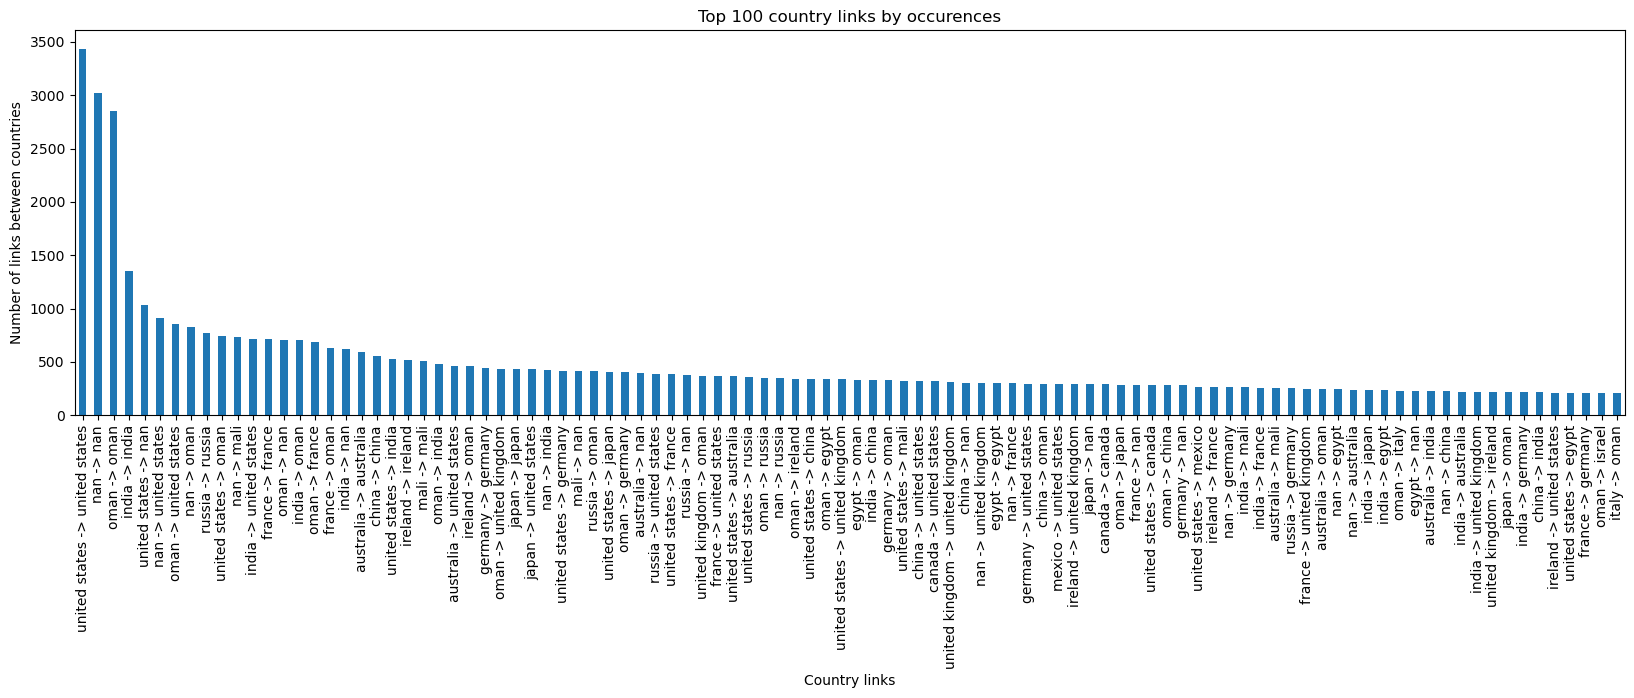

In [69]:
df = pd.DataFrame(l, columns=["links"])
df.groupby("links").size().sort_values(ascending=False).head(100).plot(kind="bar", figsize=(20, 5))
plt.ylabel("Number of links between countries")
plt.xlabel("Country links")
plt.title("Top 100 country links by occurences")

In [49]:
country_clicks

,Top_1_name,Top_2_name,Top_1_count,Top_2_count,click_count,num_links_in,name_links_in,num_links_out,name_links_out
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,ireland,oman,8.0,7.0,0,0.0,NaN,11.0,"[Bede, Columba, D%C3%A1l_Riata, Great_Britain,..."
%C3%85land,finland,åland islands,36.0,16.0,4,0.0,NaN,19.0,"[20th_century, Baltic_Sea, Crimean_War, Curren..."
%C3%89douard_Manet,oman,italy,10.0,2.0,7,0.0,NaN,20.0,"[Absinthe, Beer, Claude_Monet, Diego_Vel%C3%A1..."
%C3%89ire,ireland,canada,43.0,4.0,13,0.0,NaN,8.0,"[Canada, English_language, George_VI_of_the_Un..."
%C3%93engus_I_of_the_Picts,ireland,oman,9.0,2.0,0,0.0,NaN,10.0,"[D%C3%A1l_Riata, Durham, England, Great_Britai..."
...,...,...,...,...,...,...,...,...,...
Zirconium,india,NaN,2.0,NaN,34,15.0,"['Calcium', 'Cerium', 'Diamond_simulant', 'Gas...",42.0,"[Aluminium, Arabic_language, Australia, Bicycl..."
Zoroaster,iran,tajikistan,15.0,3.0,20,9.0,"['Friedrich_Nietzsche', 'Greco-Buddhism', 'Ira...",28.0,"[18th_century, 9th_century, Afghanistan, Age_o..."
Zuid-Gelders,netherlands,germany,2.0,2.0,10,5.0,"['Brabantian', 'Dutch_language', 'East_Flemish...",5.0,"[Brabantian, Dutch_language, East_Flemish, Hol..."
Zulu,south africa,zimbabwe,15.0,3.0,55,14.0,"['19th_century', 'Africa', 'History_of_South_A...",0.0,[]


In [67]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='click_count ~ num_links_in + num_links_out + C(Top_1_name)', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     34.38
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:28:22   Log-Likelihood:                -26457.
No. Observations:                3960   AIC:                         5.333e+04
Df Residuals:                    3750   BIC:                         5.465e+04
Df Model:                         209                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Text(0.5, 1.0, 'Coefficients of the linear regression model')

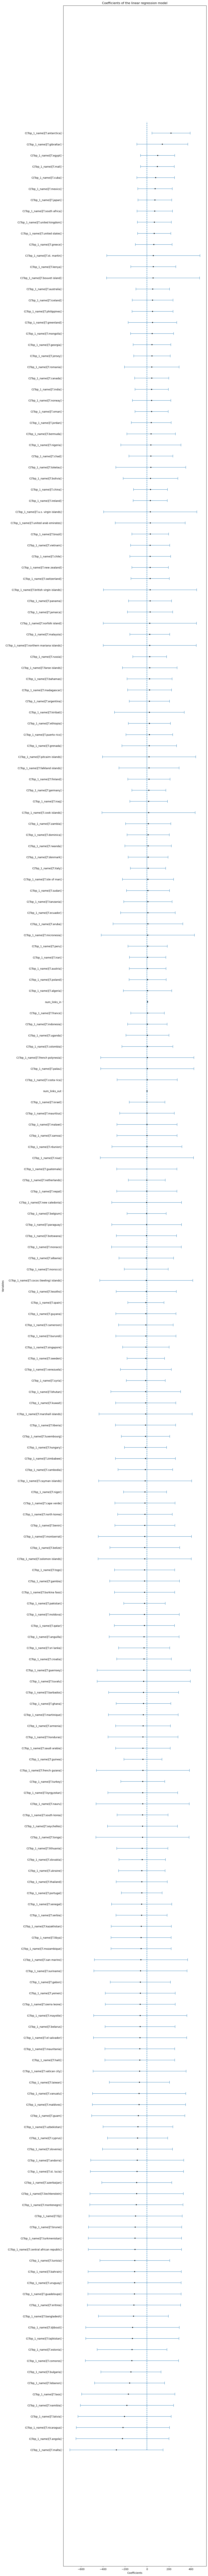

In [68]:
variables = res.params.index
coefficients = res.params.values
p_values = res.pvalues
standard_errors = res.bse.values
res.conf_int()

plt.figure(figsize=(10, 180))
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);


plt.xlabel('Coefficients')
plt.ylabel('Variables')
plt.title('Coefficients of the linear regression model')


In [56]:
mod = smf.ols(formula='click_count ~ num_links_in + num_links_out + C(Top_1_name) * Top_1_count + C(Top_2_name) * Top_2_count', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     11.42
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:19:45   Log-Likelihood:                -18340.
No. Observations:                2782   AIC:                         3.798e+04
Df Residuals:                    2133   BIC:                         4.183e+04
Df Model:                         648                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------